# 1. Description

### train.csv 
- county - An ID code for the county.
- is_business - Boolean for whether or not the prosumer is a business.
- product_type - ID code with the following mapping of codes to contract types: {0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}.
- target - The consumption or production amount for the relevant segment for the hour. The segments are defined by the county, is_business, and product_type.
- is_consumption - Boolean for whether or not this row's target is consumption or production.
- datetime - The Estonian time in EET (UTC+2) / EEST (UTC+3).
- data_block_id - All rows sharing the same data_block_id will be available at the same forecast time. This is a function of what information is available when forecasts are actually made, at 11 AM each morning. For example, if the forecast weather data_block_id for predictins made on October 31st is 100 then the historic weather data_block_id for October 31st will be 101 as the historic weather data is only actually available the next day.
- row_id - A unique identifier for the row.
- prediction_unit_id - A unique identifier for the county, is_business, and product_type combination. *New prediction units can appear or disappear in the test set*.

# 2. Import

In [1]:
import numpy as np
import pandas as pd

from matplotlib import dates as mdates
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

import seaborn as sns
import colorcet as cc

import plotly.express as px
import plotly.graph_objects as go

# from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
train_df = pd.read_csv("train.csv")
gas_prices_df = pd.read_csv("gas_prices.csv")
client_df = pd.read_csv('client.csv')
electricity_prices_df = pd.read_csv("electricity_prices.csv")
forecast_weather_df = pd.read_csv("forecast_weather.csv")
historical_weather_df = pd.read_csv("historical_weather.csv")

station_county_mapping = pd.read_csv("weather_station_to_county_mapping.csv")
county_id_to_name_map = pd.read_json(
    "county_id_to_name_map.json",
    typ="series",
).str.capitalize()

In [85]:
RAND = 10

COLORS_LIST = (
    cc.glasbey[:4]
    + [cc.glasbey[8]]
    + cc.glasbey[5:8]
    + [cc.glasbey[4]]
    + [cc.glasbey[12]]
    + cc.glasbey[10:12]
    + [cc.glasbey[9]]
    + cc.glasbey[13:16]
)
PALETTE = sns.color_palette(COLORS_LIST)

# 3. EDA

#### General

In [4]:
df = train_df.copy()
df.head()

county  is_business  product_type  target  is_consumption  \
0       0            0             1   0.713               0   
1       0            0             1  96.590               1   
2       0            0             2   0.000               0   
3       0            0             2  17.314               1   
4       0            0             3   2.904               0   

              datetime  data_block_id  row_id  prediction_unit_id  
0  2021-09-01 00:00:00              0       0                   0  
1  2021-09-01 00:00:00              0       1                   0  
2  2021-09-01 00:00:00              0       2                   1  
3  2021-09-01 00:00:00              0       3                   1  
4  2021-09-01 00:00:00              0       4                   2

In [5]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   county              2018352 non-null  int64  
 1   is_business         2018352 non-null  int64  
 2   product_type        2018352 non-null  int64  
 3   target              2017824 non-null  float64
 4   is_consumption      2018352 non-null  int64  
 5   datetime            2018352 non-null  object 
 6   data_block_id       2018352 non-null  int64  
 7   row_id              2018352 non-null  int64  
 8   prediction_unit_id  2018352 non-null  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 138.6+ MB


- The number of target values is smaller than the number of feature values.

In [6]:
df.describe().apply(lambda x: x.apply('{0:.2f}'.format))

county is_business product_type      target is_consumption  \
count  2018352.00  2018352.00   2018352.00  2017824.00     2018352.00   
mean         7.30        0.54         1.90      274.86           0.50   
std          4.78        0.50         1.08      909.50           0.50   
min          0.00        0.00         0.00        0.00           0.00   
25%          3.00        0.00         1.00        0.38           0.00   
50%          7.00        1.00         2.00       31.13           0.50   
75%         11.00        1.00         3.00      180.21           1.00   
max         15.00        1.00         3.00    15480.27           1.00   

      data_block_id      row_id prediction_unit_id  
count    2018352.00  2018352.00         2018352.00  
mean         321.87  1009175.50              33.05  
std          182.63   582648.18              19.59  
min            0.00        0.00               0.00  
25%          166.00   504587.75              16.00  
50%          323.00  1009175.50              33.00  
75%          479.00  1513763.25              50.00  
max          637.00  2018351.00              68.00

In [7]:
df.describe(include='object')

datetime
count               2018352
unique                15312
top     2022-11-27 12:00:00
freq                    138

In [8]:
# Renaming to avoid confusion and improve readability

values_mapper = {
    "county": county_id_to_name_map,
    "is_business": {0: "not_business", 1: "business"},
    "is_consumption": {0: "production", 1: "consumption"},
    "product_type": {
        0: "combined",
        1: "fixed",
        2: "general_service",
        3: "spot",
    },
}

for column in values_mapper:
    df[column] = df[column].map(values_mapper[column])

df = df.astype(
    {
        "county": "category",
        "is_business": "category",
        "product_type": "category",
        "is_consumption": "category",
        "datetime": "datetime64[ns]",
    }
)

In [9]:
# df = df.astype({
#     "county": "uint8",
#     "is_business": "bool",
#     "product_type": "uint8",
#     "is_consumption": "bool",
#     "datetime": "datetime64[ns]",})

In [10]:
# Adding new time-related features based on datetime

df["hour"] = df["datetime"].dt.hour.astype("uint8")
df["day_of_week"] = df["datetime"].dt.day_of_week.astype("uint8")
df["day"] = df["datetime"].dt.day.astype("uint16")
df["week_of_year"] = df["datetime"].dt.isocalendar().week.astype("int8")
df["month"] = df["datetime"].dt.month.astype("int8")
df["quarter"] = df["datetime"].dt.quarter.astype("int8")
df["year"] = df["datetime"].dt.year.astype("uint16")

df["date"] = df["datetime"].dt.date

#### Missing values and duplicates

In [11]:
df.isna().sum()[df.isna().sum() != 0]

target    528
dtype: int64

In [12]:
df.duplicated().sum()

0

- There is a small number (528/2018352 < 0.1%) of missing values and zero duplicates in the dataframe.
- Only the target column has missing values.

In [13]:
df[df.isna().any(axis=1)].head().sort_values(by=['datetime'])

county   is_business     product_type  target is_consumption  \
178938  Harjumaa  not_business            fixed     NaN     production   
178939  Harjumaa  not_business            fixed     NaN    consumption   
178940  Harjumaa  not_business  general_service     NaN     production   
178941  Harjumaa  not_business  general_service     NaN    consumption   
178942  Harjumaa  not_business             spot     NaN     production   

                  datetime  data_block_id  row_id  prediction_unit_id  hour  \
178938 2021-10-31 03:00:00             60  178938                   0     3   
178939 2021-10-31 03:00:00             60  178939                   0     3   
178940 2021-10-31 03:00:00             60  178940                   1     3   
178941 2021-10-31 03:00:00             60  178941                   1     3   
178942 2021-10-31 03:00:00             60  178942                   2     3   

        day_of_week  day  week_of_year  month  quarter  year        date  
178938            6   31            43     10        4  2021  2021-10-31  
178939            6   31            43     10        4  2021  2021-10-31  
178940            6   31            43     10        4  2021  2021-10-31  
178941            6   31            43     10        4  2021  2021-10-31  
178942            6   31            43     10        4  2021  2021-10-31

- The datetime for missing target values started not from '2021-09-01 00:00:00'.

In [14]:
na_datetimes = df[df.isna().any(axis=1)].datetime.unique()
na_datetimes

<DatetimeArray>
['2021-10-31 03:00:00', '2022-03-27 03:00:00', '2022-10-30 03:00:00',
 '2023-03-26 03:00:00']
Length: 4, dtype: datetime64[ns]

- All missing values correspond to the first/last hours of daylight saving time.

In [15]:
df.loc[df['datetime'].isin(na_datetimes), ['target']].shape[0]

528

- All target values at these timestamps are missing.

#### Target distribution

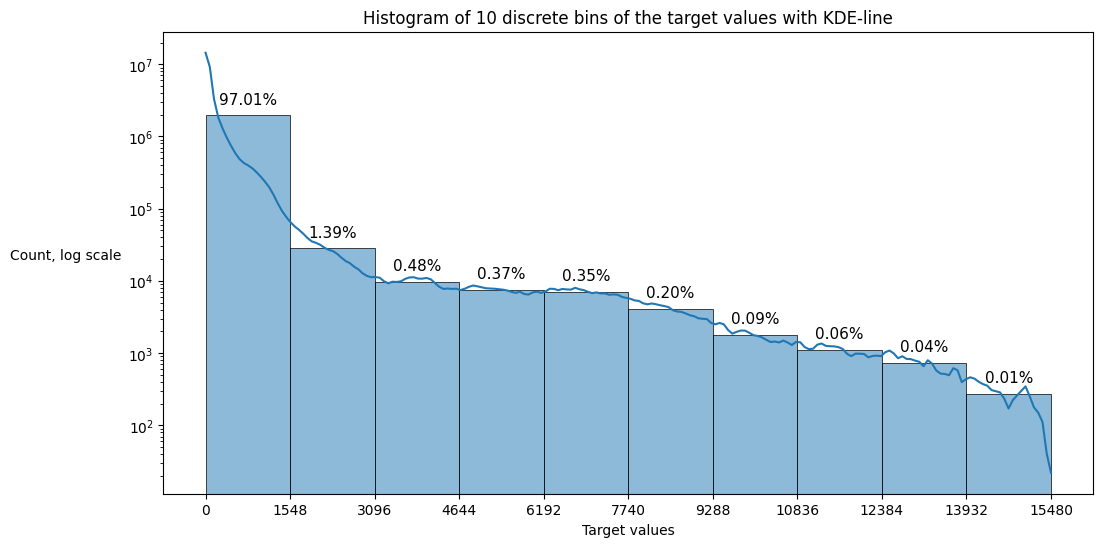

In [16]:
# Creating target's discrete intervals
bins = 10
plt.figure(figsize=(12, 6))

target_bins_percentage = round(
    pd
    .cut(np.array(df.target), bins, precision=0)
    .value_counts()
    / df.shape[0]
    * 100,
    2)

# Re-calculate first value so
# that the sum of the percentages is equal to 100.0
target_bins_percentage[0] = 100 - target_bins_percentage[1:].sum()
target_bins_percentage = [f"{i:.2f}%" for i in target_bins_percentage]

target_max = df.target.max()
ticks = range(0, int(target_max) + 1, int(target_max / bins))

ax = sns.histplot(df.target, bins=bins, kde=True, linewidth=.5,)

# Adding group percentage to the top of each bar
ax.bar_label(ax.containers[0], target_bins_percentage, padding=6, fontsize=11)

plt.title('Histogram of 10 discrete bins of the target values with KDE-line')
plt.xticks(ticks=ticks, rotation=0)
plt.xlabel("Target values")

# Using a logarithmic scale for the y-axis for better visualization
# of small quantities of target values
plt.yscale("log")
plt.ylabel("Count, log scale", rotation=0, labelpad=45)
plt.show()

- The target distribution is non-normal, it is right-skewed.
- There are more values in the first discrete bin than the total number in the rest; the KDE-line shows that most of the values are near zero.

In [17]:
levels = 5 # The number of boxenplot levels plus 2 (min and max)

# list with data for additional lines and text
# started from .25 because lower corresponding percentiles are the same

levels_list = [.25] + np.cumsum(
    [.5 / pow(2, i) for i in range(levels - 1)]).tolist()
levels_values = df.target.describe(levels_list)[3:]

In [18]:
levels_values.values

array([0.00000000e+00, 3.78000000e-01, 3.11330000e+01, 1.80206250e+02,
       4.97500000e+02, 9.39845188e+02, 1.54802740e+04])

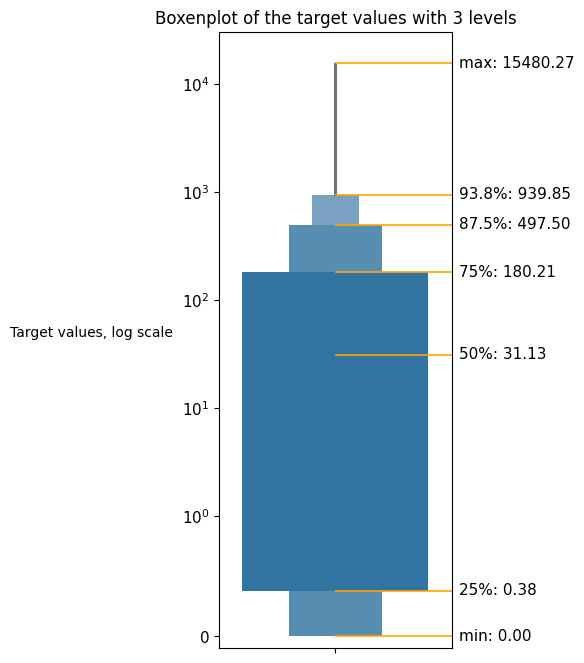

In [19]:
plt.figure(figsize=(3, 8))
ax = sns.boxenplot(
    df,
    y="target",
    linewidth=0,
    k_depth=levels - 2,
    flier_kws={
        'marker': '.',
        's': .1,
    })

ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1])

plt.hlines(
    levels_values.values,
    0,
    ax.get_xlim()[1],
    'orange',
    lw=1.2,
)

for ix, l in enumerate(levels_values):
    plt.text(
        ax.get_xlim()[1] + .03,
        levels_values.values[ix],
        f'{levels_values.index[ix]}: {levels_values.values[ix]:.2f}',
        fontsize=11,
        ha='left',
        va='center',
    )

ax.set_ylim(-.1, 30_000)
plt.yscale('symlog', linthresh=1)
plt.title('Boxenplot of the target values with 3 levels')
plt.ylabel("Target values, log scale", rotation=0, labelpad=65)
plt.yticks(fontsize=11)
plt.show()

- Q<sub>1</sub> ≈ 0.38
- Q<sub>2</sub> ≈ 31.13
- Q<sub>3</sub> ≈ 180.21
- There are only two levels on the Q<sub>1</sub> side of the boxenplot (as opposed to three levels on the Q<sub>3</sub> side), which means that there is a huge number of identical values that cannot be separated. That is, two different percentiles (6.25% and 12.5%) have the same value, which equal to the minimum value - 0.

In [20]:
df.target.value_counts().head()

target
0.000    351496
0.001     10733
0.003      6619
0.002      5365
0.004      4593
Name: count, dtype: int64

In [21]:
df.target.count()

2017824

- Zero values are the most common and occur in more than 10 percent of the cases (351496 / 2017824).

#### County, is_business, and product_type combinations

In [22]:
df_categories = (df.groupby(
    [
        "county",
        "is_business",
        "product_type",
        "is_consumption",
    ],
    observed=True,
)["target"].count().reset_index())
df_categories["county_num"] = df_categories["county"].map(
    pd.Series(county_id_to_name_map.index, county_id_to_name_map.values))
df_categories.head()

county is_business     product_type is_consumption  target county_num
0  Harjumaa    business         combined    consumption   15308          0
1  Harjumaa    business         combined     production   15308          0
2  Harjumaa    business            fixed    consumption   15308          0
3  Harjumaa    business            fixed     production   15308          0
4  Harjumaa    business  general_service    consumption   14588          0

In [23]:
# Create dimensions for each column
county_dim = go.parcats.Dimension(values=df_categories.county, label="County")
is_business_dim = go.parcats.Dimension(
    values=df_categories.is_business, label="Is business?"
)
product_type_dim = go.parcats.Dimension(
    values=df_categories.product_type, label="Product type"
)
is_consumption_dim = go.parcats.Dimension(
    values=df_categories.is_consumption, label="Is consumption?"
)
county_num_dim = go.parcats.Dimension(
    values=df_categories.county_num, label="County_num"
)

color = df_categories.county_num
colorscale = px.colors.make_colorscale(COLORS_LIST)

fig = go.Figure(
    data=[
        go.Parcats(
            dimensions=[
                county_dim,
                product_type_dim,
                is_business_dim,
                is_consumption_dim,
            ],
            line={"color": color, "colorscale": colorscale},
            hoveron="dimension",
            labelfont={"size": 16, "family": "sans-serif"},
            tickfont={"size": 16, "family": "sans-serif", "color": "blue"},
            arrangement="freeform",
        )
    ]
)
fig.update_layout(
    width=1200,
    height=800,
    font={"size": 18, "family": "sans-serif"},
    title="Parallel categories diagram for all observed combinations of catego\
rical features",
)
fig.show()

- There are different combinations of county-product_type-is_business features. All these combinations have two variants for is_consumption feature. What this means is that it is possible for each timestamp there are two target values for county-product_type-is_business combinations corresponding to consumption and production.
- Only two counties have one combiation of product_type-is_business features: Läänemaa and Unknown. Both of them have only 'spot' and 'business' values in corresponding features.
- It is worth noting that the description of prediction_unit_id says that new combinations of county, is_business, and product_type features may appear or disappear.

In [24]:
# Checking the first point

# There are no timestamps in the dataframe,
# for which there are only consumption or production values.

In [25]:
def create_prodcons_df(
    df: pd.DataFrame,
    compare: str,
    # group: list[str],
) -> pd.DataFrame:
    df = (
        df.loc[df["is_consumption"] == compare]
        .groupby(
            ["datetime", "county", "is_business", "product_type"],
            observed=True,
        )["target"]
        .count()
        .reset_index()
    )
    return df

In [26]:
create_prodcons_df(df, 'consumption')

datetime    county   is_business     product_type  target
0       2021-09-01 00:00:00  Harjumaa      business         combined       1
1       2021-09-01 00:00:00  Harjumaa      business            fixed       1
2       2021-09-01 00:00:00  Harjumaa      business             spot       1
3       2021-09-01 00:00:00  Harjumaa  not_business            fixed       1
4       2021-09-01 00:00:00  Harjumaa  not_business  general_service       1
...                     ...       ...           ...              ...     ...
1009171 2023-05-31 23:00:00   Võrumaa      business         combined       1
1009172 2023-05-31 23:00:00   Võrumaa      business            fixed       1
1009173 2023-05-31 23:00:00   Võrumaa      business             spot       1
1009174 2023-05-31 23:00:00   Võrumaa  not_business            fixed       1
1009175 2023-05-31 23:00:00   Võrumaa  not_business             spot       1

[1009176 rows x 5 columns]

In [27]:
create_prodcons_df(df, 'consumption').equals(create_prodcons_df(df, 'production'))

True

Yes, the first point is correct.
For each combinations of datetime-county-is_business-product_type features there are one consumption value and one production value (including nan values).

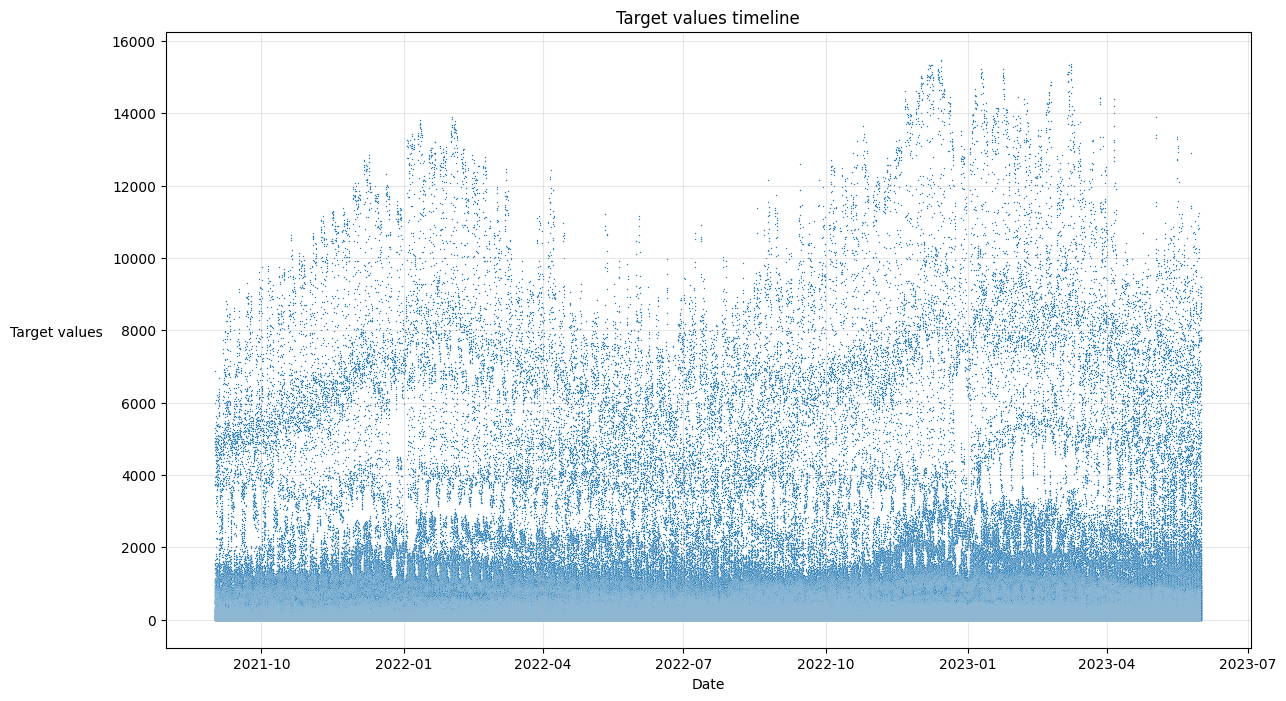

In [28]:
fig, ax = plt.subplots(figsize=(14, 8))
sns.scatterplot(data=df, x="datetime", y="target", s=1,)

plt.title("Target values timeline")
plt.xlabel("Date")
plt.ylabel("Target values", rotation=0, labelpad=40)
plt.grid(alpha=.3)
plt.show()

- Values less than 1500 are indistinguishable, the point density is too high for this plot.
- The target variable has seasonal and weekly cycles.
- There are 'voids' during the New Year holidays.

In [29]:
# Consumption values are multiplied by (-1) for better visualisation

df["modified_target"] = np.where(
    df["is_consumption"] == 'consumption',
    df["target"].mul(-1),
    df["target"],
)

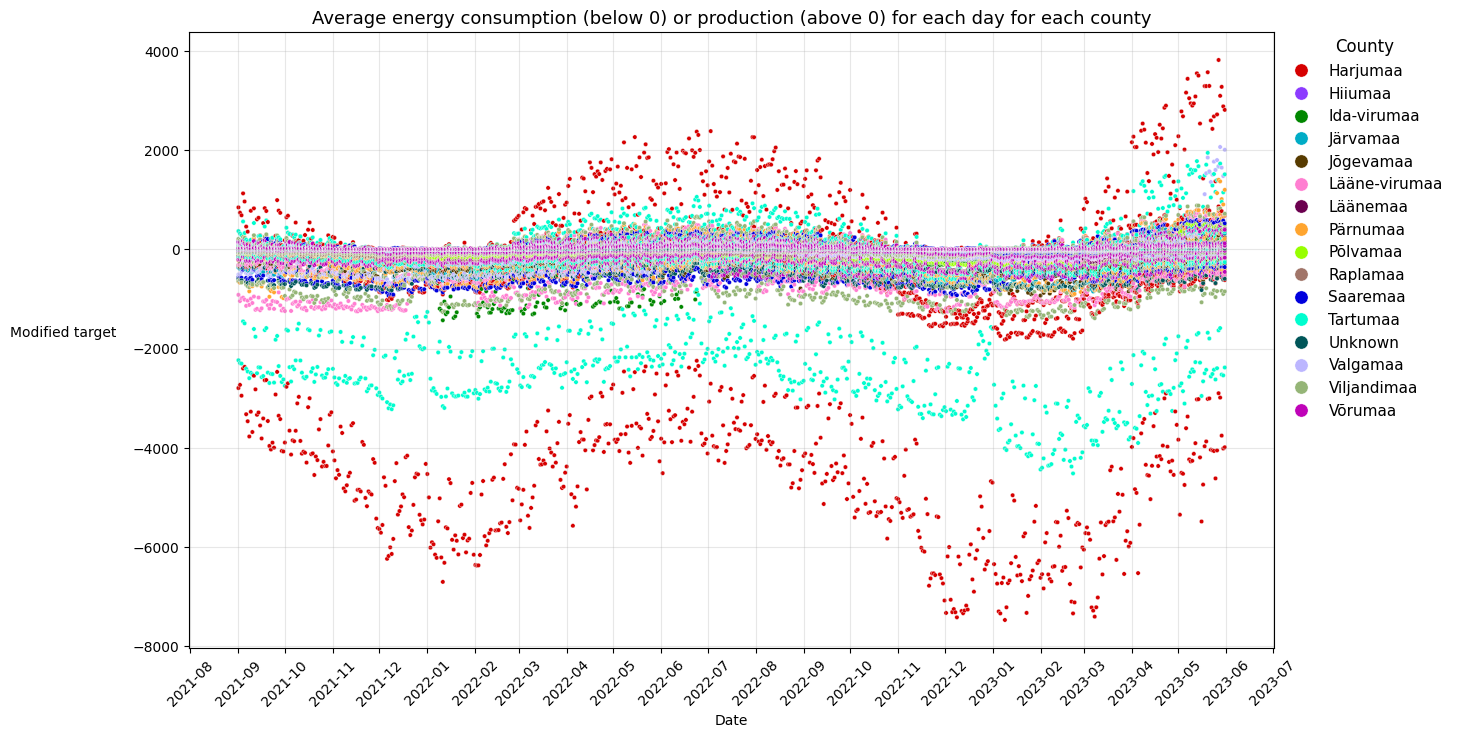

In [30]:
fig, ax = plt.subplots(figsize=(14, 8))
sns.scatterplot(
    df.groupby(
        ["date", "is_consumption", "county", "product_type"], observed=True
    )["modified_target"]
    .mean()
    .reset_index(name="modified_target"),
    # df,
    x="date",
    # x="datetime",
    y="modified_target",
    hue="county",
    palette=PALETTE,
    s=10,
)

plt.title(
    "Average energy consumption (below 0) or production (above 0) for each \
day for each county",
    fontsize=13,
)

plt.legend(
    title="County",
    title_fontsize=12,
    bbox_to_anchor=(1.005, 1),
    loc="upper left",
    borderaxespad=0,
    markerscale=3,
    frameon=False,
    fontsize=11,
)

months_locator = mdates.MonthLocator()
ax.xaxis.set_major_locator(months_locator)

plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Modified target", rotation=0, labelpad=50)
plt.grid(alpha=0.3)
plt.show()

1. Electricity consumption and production values are increasing from year to year.
2. Energy production in winter is significantly lower than in summer.
3. Energy consumption in winter is bigger than in summer.
4. During the New Year holidays, there is a decrease in electricity consumption.
5. Harjumaa county has highest average (per day) values of energy consumption (for the entire observation period) and production (for spring-autumn period). Tartumaa has second highest values for the entire observation period except last two weeks when Valgamaa get ahead in energy production.

In [31]:
# Checking the first point

# Electricity consumption and production values are
# increasing from year to year.

In [32]:
# Due to only one year being fully available,
# the other two years will be compared with respective months of 2022.

In [33]:
def create_target_comparison_by_year(
    df: pd.DataFrame,
    first_year: int,
    second_year: int,
) -> pd.DataFrame:

    if df[df["year"] == first_year].month.unique().size == 12:
        complete_year = first_year
        incomplete_year = second_year
    else:
        complete_year = second_year
        incomplete_year = first_year

    grouped = (df
               .loc[df["year"].isin([incomplete_year, complete_year]) & df.month.isin(df[df["year"] == incomplete_year].month.unique())]
               .groupby(["is_consumption","year",], observed=True,)["target"])

    return (pd
            .merge(
                grouped.describe(),
                grouped.sum(),
                on=["is_consumption", "year"])
            .rename(columns={"target": "sum"})
            .reset_index()
            .melt(id_vars=["year", "is_consumption"])
           )

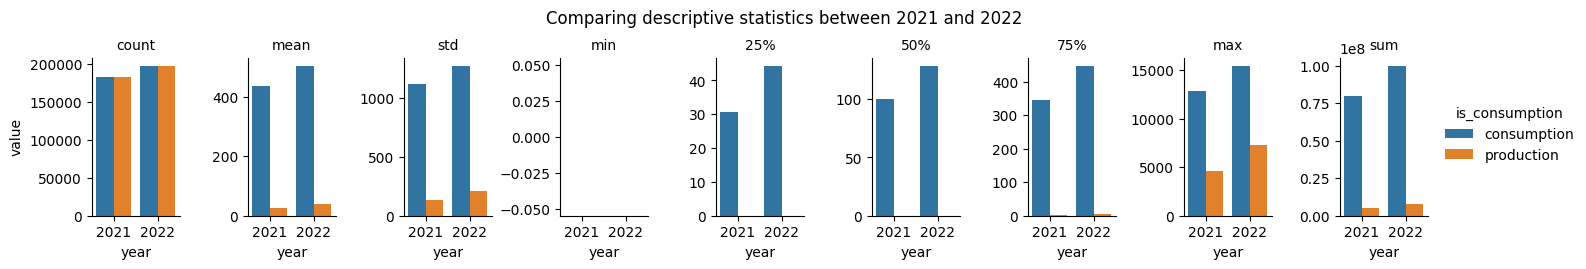

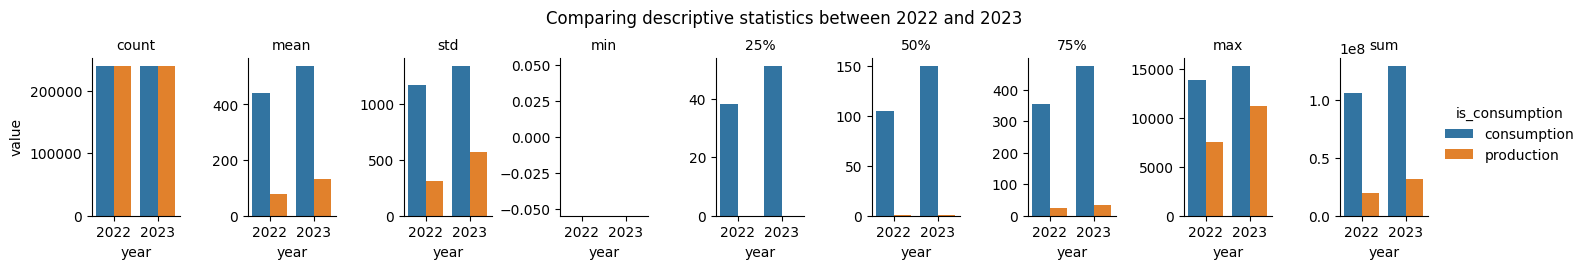

In [34]:
for year in [2021, 2023]:
    ax = sns.catplot(
        create_target_comparison_by_year(df, year, 2022),
        kind="bar",
        x="year",
        y="value",
        col="variable",
        hue="is_consumption",
        sharey=False,
        height=2.7,
        aspect=0.6,
    ).set_titles("{col_name}")
    ax.fig.subplots_adjust(top=0.8)
    if year > 2022:
        ax.fig.suptitle(f"Comparing descriptive statistics between 2022 and \
{year}")
    else:
        ax.fig.suptitle(f"Comparing descriptive statistics between {year} and \
2022")
    plt.show()

Yes, the first point is correct.
- Total sum, quartiles, means and maximum values increase from year to year. The standard deviation also increase. The minimum value does not change; it is zero. None of the descriptive statistics decrease.

In [35]:
# Checking the second point
# It appears that the relative growth rate of energy production is
# growing faster than the relative growth rate of consumption.

In [36]:
# def calculate_difference_percentage(
#     base_df: pd.DataFrame,
#     first_year: int,
#     second_year: int,
# ) -> pd.DataFrame:

#     df = create_target_comparison_by_year(base_df, first_year, second_year)
#     # .sort_values(by=["is_consumption", "year" , "variable"])
#     # df = df[df["variable"].isin(["50%", "max", "mean", "sum"])]

#     first_df = df[df["year"] == first_year].reset_index(drop=True)
#     second_df = df[df["year"] == second_year].reset_index(drop=True)

#     percent = (
#         (second_df.value - first_df.value) / first_df.value * 100
#     ).rename("percentage_difference")
#     second_df = pd.concat(
#         [
#             second_df.drop(columns=["value"]),
#             first_df["value"].rename("previous_value"),
#             second_df.value,
#             percent,
#         ],
#         axis=1,
#     )

#     return second_df

In [37]:
# calculate_difference_percentage(df, 2022, 2023)

In [38]:
# percentage_df = pd.concat([
#     calculate_difference_percentage(df, 2022, 2023),
#     calculate_difference_percentage(df, 2021, 2022),
# ]).reset_index(drop=True)
# # percentage_df

In [39]:
# ax = sns.catplot(
#     percentage_df,
#     x="year",
#     y="percentage_difference",
#     row="is_consumption",
#     col="variable",
#     kind="bar",
#     hue='is_consumption',
#     sharey=False,
#     height=2.5,
#     aspect=0.6,
#     # height=3,
#     # aspect=1,
#     margin_titles=True
# )
# ax.fig.subplots_adjust(top=0.88)
# ax.fig.suptitle('Visualisation the difference between two years in percent')
# # ax.tick_params(axis='x', rotation=30)
# plt.show()
# The second bar of the first barplot is missing because median value for the corresponding previous year months (2021 year, months from 9 to 12) was 0 and for this case growth is uncountable in percent.
# Yes, the third point is correct.

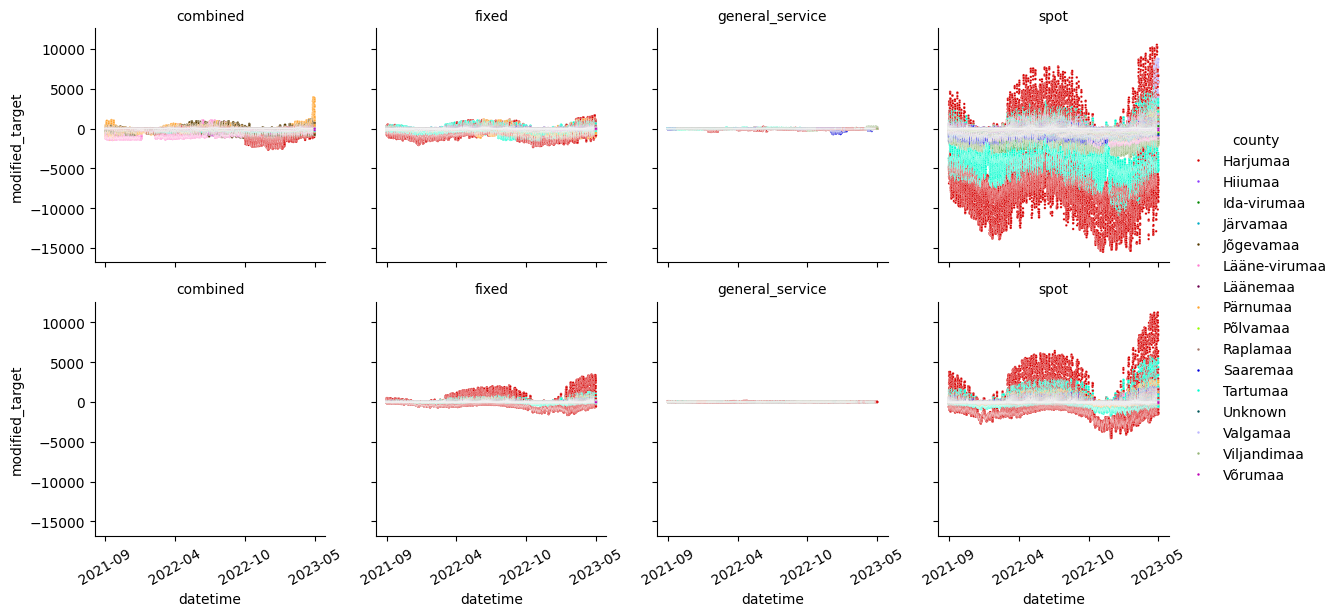

In [40]:
date_range = pd.date_range(df.datetime.min(), df.datetime.max(), 4)

ax = sns.relplot(
    data=df,
    x="datetime",
    y="modified_target",
    row="is_business",
    col="product_type",
    hue="county",
    palette=PALETTE,
    height=3,
    s=3,
)
ax.set_titles("{col_name}")
ax.set(xticks=date_range)
ax.set_xticklabels(date_range, rotation=30,)
ax.axes[0, 0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.show()

# Conclusion from relplot

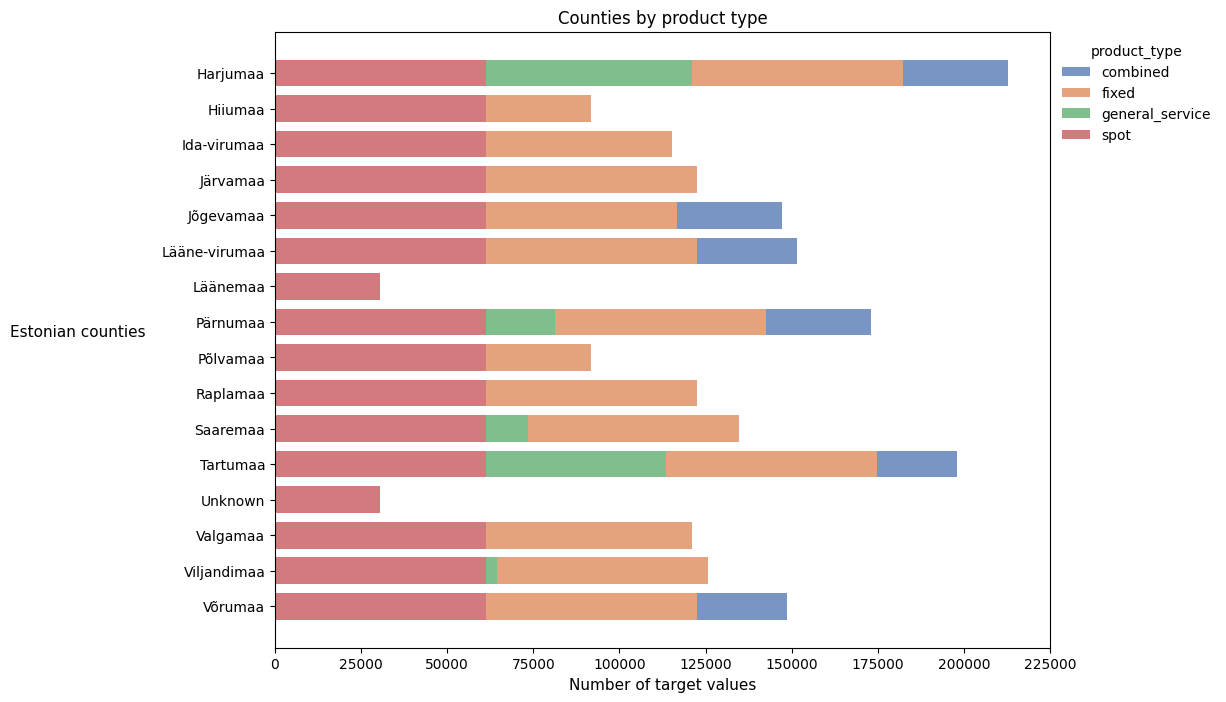

In [41]:
plt.figure(figsize=(10, 8))
plt.rcParams["patch.edgecolor"] = "none"

ax = sns.histplot(
    data=df[["county","product_type",]],
    y="county",
    hue="product_type",
    multiple="stack",
    shrink=0.75,
    palette="deep",
)

sns.move_legend(
    ax,
    "upper left",
    bbox_to_anchor=(1, 1),
    title="product_type",
    frameon=False,
)

plt.title("Counties by product type",)
plt.xticks(ticks=range(0, int(2.5e5), int(2.5e4)),)
plt.xlabel("Number of target values",fontsize=11,)
plt.ylabel("Estonian counties", rotation=0, labelpad=60, fontsize=11)

plt.show()
plt.rcParams["patch.edgecolor"] = "black"

1. Counties have different numbers of total records and ratios of contract types.
2. First place by the count of records is the 'Spot' product type, the second place is 'Fixed' product type. Third place is most likely the 'Combined' product type.
3. It seems that for the "spot" product type, the number of records for all counties is approximately 60000, except for Läänemaa and Unknown counties, where the number of records is approximately 30000.
4. Some counties don't have certain types of contracts. In the records of Läänemaa and Unknown county there is only one type of product.

In [42]:
# Checking the second point
# First place by the count of records is the 'Spot' product type,
# the second place is 'Fixed' product type.
# Third place is most likely the 'Combined' product type.

In [43]:
df.groupby(["product_type"], observed=True)[["target"]].count().sort_values(
    "target", ascending=False
)

target
product_type           
spot             918480
fixed            781428
combined         170500
general_service  147416

Yes, the second point is correct.

In [44]:
# Checking the third point
# It seems that for the "spot" product type, the number of records
# for all counties is approximately 60000, except for Läänemaa and
# Unknown counties, where the number of records is approximately 30000.

In [45]:
df.groupby(["county", "product_type"], observed=True)[
    ["target"]
].count().query('product_type == "Spot"').target.unique()

array([], dtype=int64)

Yes, the third point is correct.

Comparing the total number of records in each subgroup (all combinations of "county", "product_type", "is_business", "is_consumption" that appear in the dataframe) due to the fact that counties have different total number of records and ratios of contract types.

In [46]:
# Reordering columns
# df_categories = df_categories.copy()[[
#     "county",
#     "product_type",
#     "is_business",
#     "is_consumption",
#     "target",
#     "county_num",
# ]]

In [47]:
df_categories["subgroup"] = (
    df_categories[["county", "product_type", "is_business", "is_consumption"]]
    .astype(str)
    .agg("-".join, axis=1)
)
df_categories.head()

county is_business     product_type is_consumption  target county_num  \
0  Harjumaa    business         combined    consumption   15308          0   
1  Harjumaa    business         combined     production   15308          0   
2  Harjumaa    business            fixed    consumption   15308          0   
3  Harjumaa    business            fixed     production   15308          0   
4  Harjumaa    business  general_service    consumption   14588          0   

                                        subgroup  
0         Harjumaa-combined-business-consumption  
1          Harjumaa-combined-business-production  
2            Harjumaa-fixed-business-consumption  
3             Harjumaa-fixed-business-production  
4  Harjumaa-general_service-business-consumption

In [48]:
# count_df = (
#     df.groupby([
#         "county",
#         "product_type",
#         "is_business",
#         "is_consumption",
#     ], observed=True,)["target"].count().reset_index()
# )
# count_df["subgroup"] = (
#     count_df[["county", "product_type", "is_business", "is_consumption"]]
#     .astype(str)
#     .agg("-".join, axis=1)
# )
# count_df.head()

# first_part_df = count_df[count_df['county'].isin(count_df.county.unique()[:int(count_df.county.nunique() / 2)])]
# second_part_df = count_df[count_df['county'].isin(count_df.county.unique()[int(count_df.county.nunique() / 2):])]

In [49]:
df_categories

county   is_business     product_type is_consumption  target  \
0    Harjumaa      business         combined    consumption   15308   
1    Harjumaa      business         combined     production   15308   
2    Harjumaa      business            fixed    consumption   15308   
3    Harjumaa      business            fixed     production   15308   
4    Harjumaa      business  general_service    consumption   14588   
..        ...           ...              ...            ...     ...   
133   Võrumaa      business             spot     production   15308   
134   Võrumaa  not_business            fixed    consumption   15308   
135   Võrumaa  not_business            fixed     production   15308   
136   Võrumaa  not_business             spot    consumption   15308   
137   Võrumaa  not_business             spot     production   15308   

    county_num                                       subgroup  
0            0         Harjumaa-combined-business-consumption  
1            0          Harjumaa-combined-business-production  
2            0            Harjumaa-fixed-business-consumption  
3            0             Harjumaa-fixed-business-production  
4            0  Harjumaa-general_service-business-consumption  
..         ...                                            ...  
133         15               Võrumaa-spot-business-production  
134         15         Võrumaa-fixed-not_business-consumption  
135         15          Võrumaa-fixed-not_business-production  
136         15          Võrumaa-spot-not_business-consumption  
137         15           Võrumaa-spot-not_business-production  

[138 rows x 7 columns]

In [50]:
first_part_df = df_categories[df_categories['county'].isin(df_categories.county.unique()[:int(df_categories.county.nunique() / 2)])]
second_part_df = df_categories[df_categories['county'].isin(df_categories.county.unique()[int(df_categories.county.nunique() / 2):])]

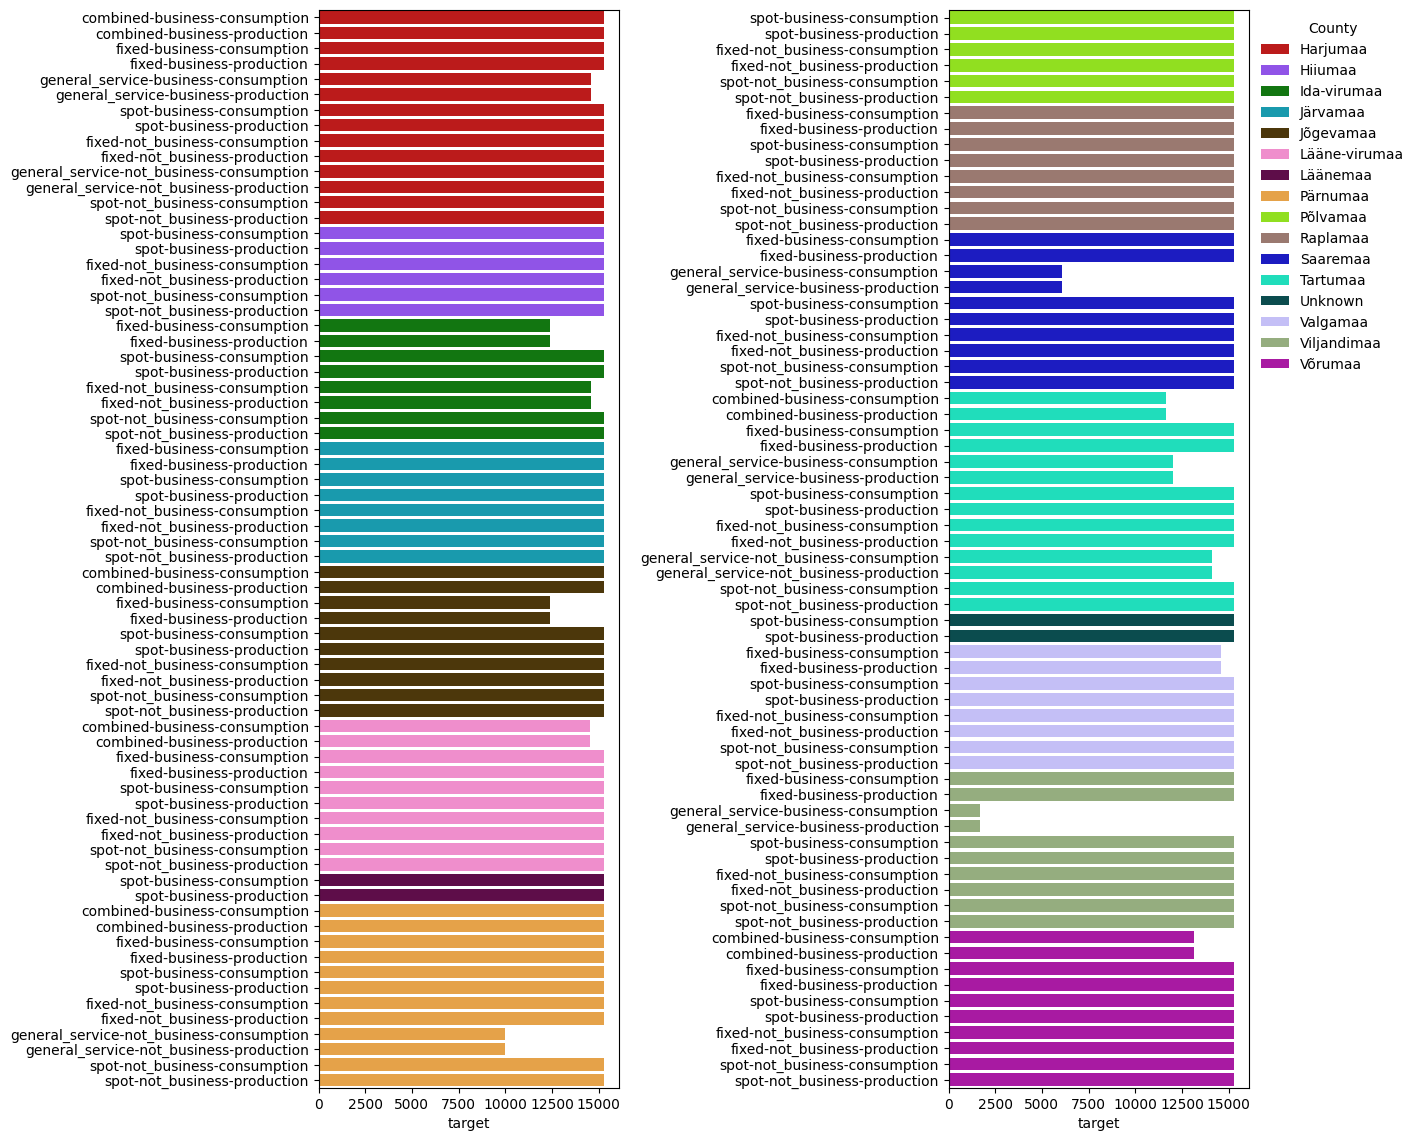

In [51]:
rows = 1
cols = 2
categories = [first_part_df, second_part_df]

fig, ax = plt.subplots(
    nrows=rows,
    ncols=cols,
    figsize=(12, 14)
)
plt.subplots_adjust(
    wspace=1.1,
)
for ind, column in enumerate(categories):
    plt.subplot(rows, cols, ind + 1)
    data = categories[ind]
    ax = sns.barplot(
        data=data,
        x='target',
        y='subgroup',
        hue='county',
        palette=PALETTE,
    )
    ax.set_yticks([i for i in range(data.subgroup.nunique())])
    ax.set_yticklabels(
        data.subgroup.apply(lambda x: '-'.join(x.split('-')[-3:])),)
    if ind == 0:
        ax.legend_.remove()
    else:
        sns.move_legend(
            ax,
            "upper left",
            bbox_to_anchor=(1, 1),
            title='County',
            frameon=False,
        )
    plt.ylabel(ylabel="",)
plt.show()

In [52]:
df_categories['target'].value_counts()

target
15308    112
14588      6
12381      4
14564      2
9981       2
6070       2
11637      2
11997      2
14108      2
1656       2
13125      2
Name: count, dtype: int64

# conclusions from BARPLOT

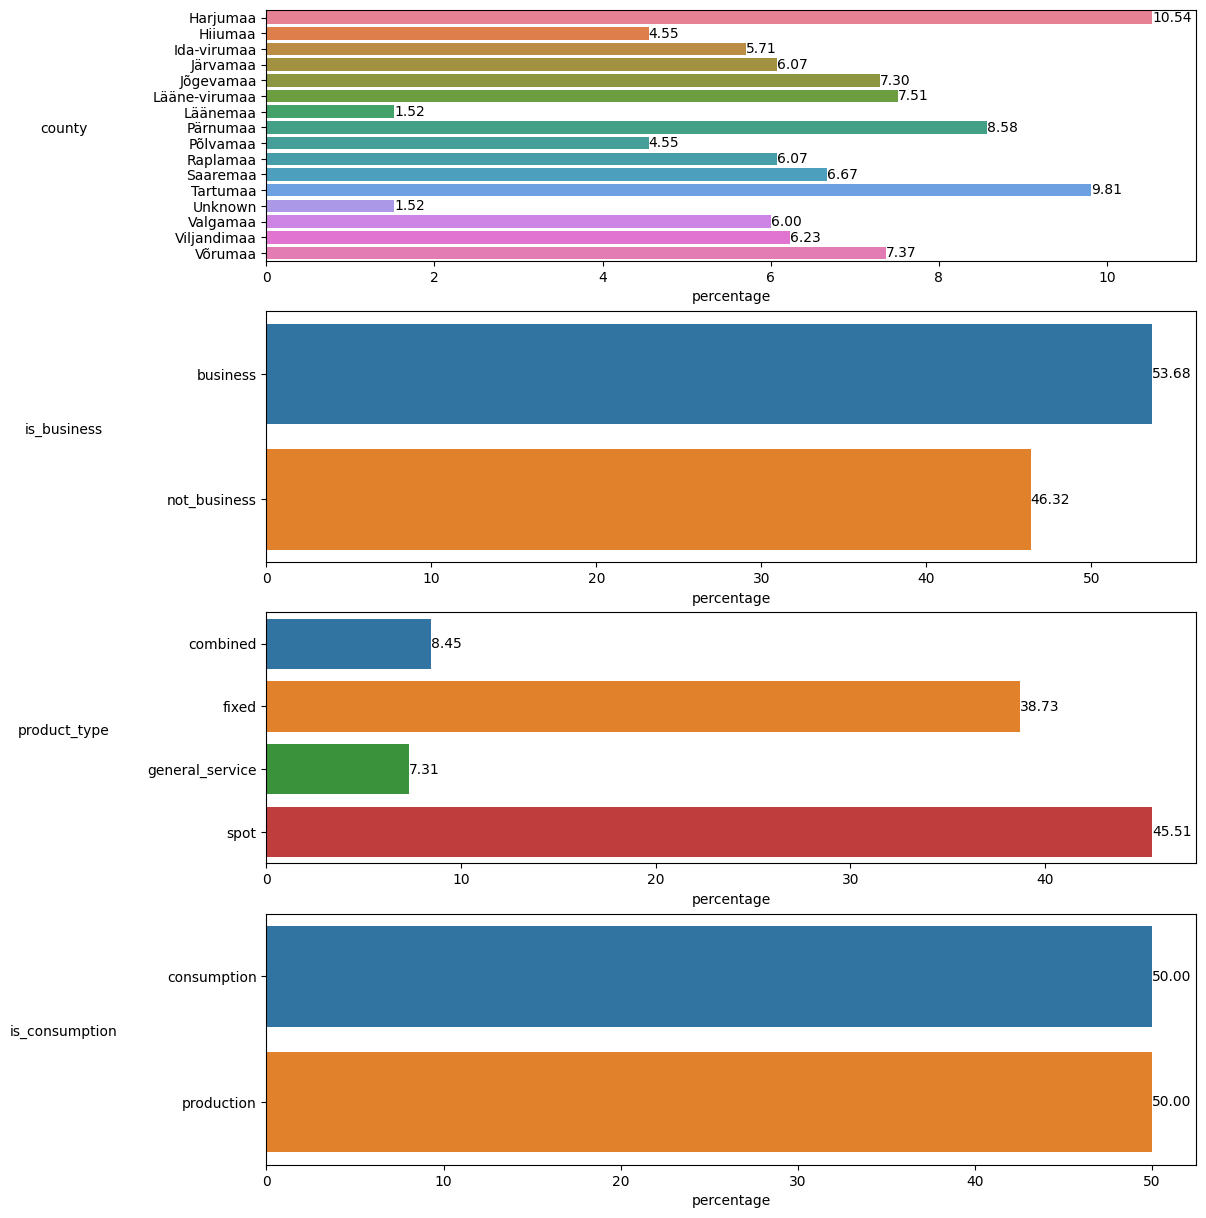

In [53]:
rows = 4
cols = 1
categories = ['county', 'is_business', 'product_type', 'is_consumption']

fig, ax = plt.subplots(
    nrows=rows,
    ncols=cols,
    figsize=(12, 15),
)

for ind, column in enumerate(categories):
    plt.subplot(rows, cols, ind + 1)
    data = (df[column].value_counts(
        normalize=True).rename("percentage").mul(100).reset_index().round(2))

    # Rounding for total sum == 100.0
    data['percentage'] = (data['percentage'].transform(lambda x: pd.Series({
        x.index[0]: (100 - x.iloc[1:].sum())
    }).combine_first(x)))

    barplot = sns.barplot(
        data=data,
        y=column,
        x="percentage",
        hue=column,
        orient='h',
        legend=False,
        # palette=PALETTE,
    )
    for container in barplot.containers:
        barplot.bar_label(
            container,
            fmt=f"%.{2}f",
        )

    # plt.legend('', frameon=False)
    plt.ylabel(
        column,
        rotation=0,
        labelpad=60,
    )

fig.align_ylabels()
plt.show()

# conclusions from BARPLOT

In [54]:
# target_business = sns.relplot(
#     data=df,
#     x="datetime",
#     y="modified_target",
#     col="is_business",
#     hue="county",
#     height = 8,
#     # aspect = 1.6,
#     # size="size",
#     # style="sex",
#     palette=PALETTE,
#     s=1,
# )
# # l = target_business._legend

In [55]:
# fig, ax = plt.subplots(figsize=(18, 8))
# sns.boxenplot(
#     data=df,
#     x="county",
#     y="target",
#     hue="is_consumption",
#     # k_depth = 'full'
#     # split=True,
#     # style='is_business',
# )

# plt.title(
#     "Comparison of energy production and consumption in each county"
# )
# # plt.legend(
# #     bbox_to_anchor=(1.005, 1),
# #     loc="upper left",
# #     borderaxespad=0,
# #     # markerscale=3,
# # )

# for i in range(df.county.nunique()):
#     ax.axvline(
#         i -.5,
#         color="black",
#         alpha=.2
#     )

# plt.xticks(rotation=45)

# plt.yscale('log')
# # plt.grid(axis='y',alpha=.2)

# plt.show()

In [56]:
data = (
    df.groupby(["date", "product_type", "county"], observed=True)["target"]
    .mean()
    .reset_index(name="target")
)
data = data.astype({"date": "datetime64[ns]"})

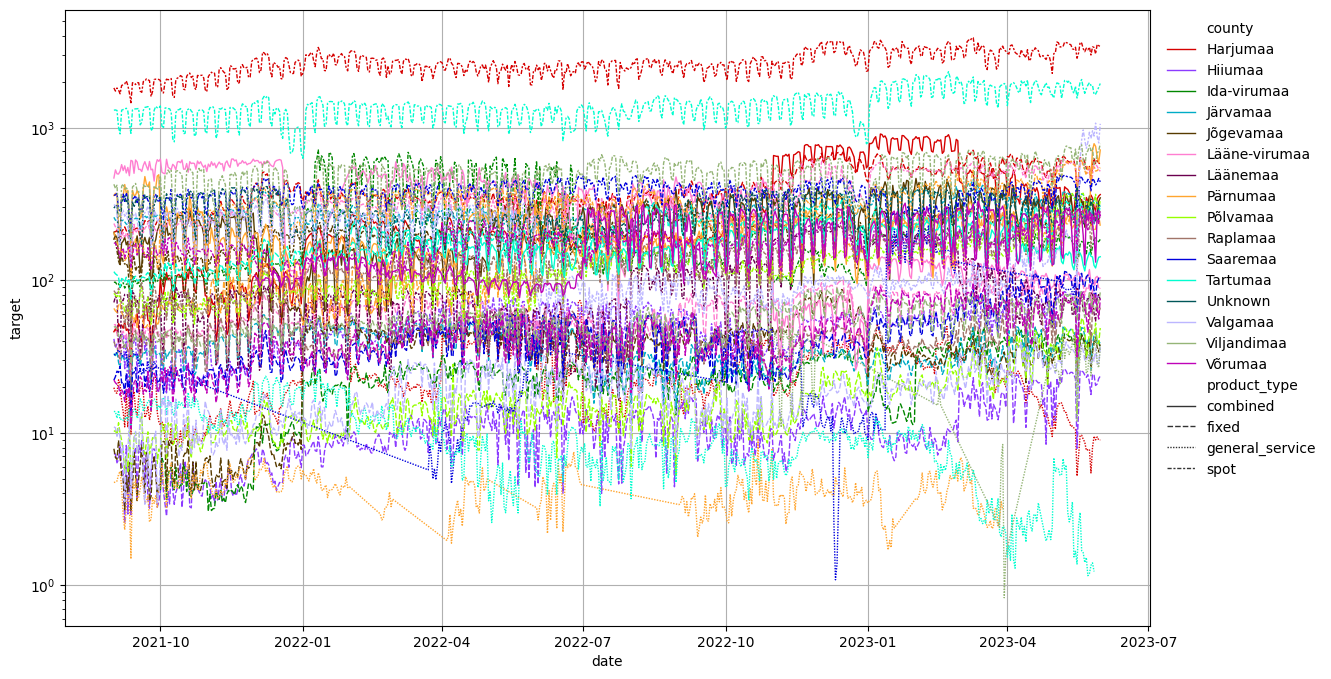

In [57]:
# Visualization of missing data and zeros using lineplot of the daily average

plt.figure(figsize=(14, 8))

ax = sns.lineplot(
    data=data,
    x="date",
    y="target",
    style="product_type",
    hue="county",
    lw=1,
    palette=PALETTE,
)
ax.grid()
ax.set_yscale('log')
ax.legend(loc="upper left", bbox_to_anchor=(1.005, 1), frameon=False)
plt.show()

In [58]:
data.query('county == "Saaremaa" and "2021-02-01" <= date <= "2021-02-01" ')

Empty DataFrame
Columns: [date, product_type, county, target]
Index: []

In [59]:
data.query('product_type == "general_service" and county == "Pärnumaa" and ("2021-02-01" < date < "2021-03-01")')

Empty DataFrame
Columns: [date, product_type, county, target]
Index: []

In [60]:
data.county.unique().tolist()

['Harjumaa',
 'Jõgevamaa',
 'Lääne-virumaa',
 'Pärnumaa',
 'Hiiumaa',
 'Järvamaa',
 'Põlvamaa',
 'Raplamaa',
 'Saaremaa',
 'Tartumaa',
 'Valgamaa',
 'Viljandimaa',
 'Võrumaa',
 'Ida-virumaa',
 'Läänemaa',
 'Unknown']

In [61]:
# df_for_missing = train_df.drop(columns=['data_block_id', 'row_id', 'prediction_unit_id']).copy()

In [62]:
# # Renaming to avoid confusion and improve readability
# values_mapper = {
#     "county": county_id_to_name_map,
#     "is_business": {
#         0: "not_business",
#         1: "business"
#     },
#     "is_consumption": {
#         0: "production",
#         1: "consumption"
#     },
#     "product_type": {
#         0: "Combined",
#         1: "Fixed",
#         2: "General service",
#         3: "Spot",
#     },
# }

# for column in values_mapper:
#     df_for_missing[column] = df_for_missing[column].map(values_mapper[column])

# df_for_missing = df_for_missing.astype({
#     "county": "category",
#     "is_business": "category",
#     "product_type": "category",
#     "is_consumption": "category",
#     "datetime": "datetime64[ns]",
# })

In [63]:
df_for_missing = df[[
    'county', 'is_business', 'product_type', 'target', 'is_consumption',
    'datetime'
]].copy()

df_for_missing['hour_stamp'] = (
    (df_for_missing['datetime'] - df_for_missing['datetime'].min()) /
    pd.Timedelta(hours=1)).astype(int)

df_for_missing[[
    'hour_stamp',
    'datetime',
]].max()

hour_stamp                  15311
datetime      2023-05-31 23:00:00
dtype: object

In [64]:
df_for_missing['group_index'] = df_for_missing.groupby([
    "county",
    "is_business",
    "product_type",
    "is_consumption",
], observed=True).ngroup()

df_for_missing = df_for_missing.sort_values(['hour_stamp', 'group_index'])

In [65]:
vl = df_for_missing.values

In [66]:
vl[0]

array(['Harjumaa', 'business', 'combined', 59.0, 'consumption',
       Timestamp('2021-09-01 00:00:00'), 0, 0], dtype=object)

In [67]:
df_for_missing.head()

county is_business product_type    target is_consumption   datetime  \
7   Harjumaa    business     combined    59.000    consumption 2021-09-01   
6   Harjumaa    business     combined     0.000     production 2021-09-01   
9   Harjumaa    business        fixed   501.760    consumption 2021-09-01   
8   Harjumaa    business        fixed     0.000     production 2021-09-01   
11  Harjumaa    business         spot  5155.056    consumption 2021-09-01   

    hour_stamp  group_index  
7            0            0  
6            0            1  
9            0            2  
8            0            3  
11           0            6

In [68]:
df_for_missing

county   is_business product_type    target is_consumption  \
7        Harjumaa      business     combined    59.000    consumption   
6        Harjumaa      business     combined     0.000     production   
9        Harjumaa      business        fixed   501.760    consumption   
8        Harjumaa      business        fixed     0.000     production   
11       Harjumaa      business         spot  5155.056    consumption   
...           ...           ...          ...       ...            ...   
2018350   Võrumaa      business         spot     0.000     production   
2018343   Võrumaa  not_business        fixed    42.401    consumption   
2018342   Võrumaa  not_business        fixed     0.004     production   
2018345   Võrumaa  not_business         spot   117.332    consumption   
2018344   Võrumaa  not_business         spot     2.287     production   

                   datetime  hour_stamp  group_index  
7       2021-09-01 00:00:00           0            0  
6       2021-09-01 00:00:00           0            1  
9       2021-09-01 00:00:00           0            2  
8       2021-09-01 00:00:00           0            3  
11      2021-09-01 00:00:00           0            6  
...                     ...         ...          ...  
2018350 2023-05-31 23:00:00       15311          133  
2018343 2023-05-31 23:00:00       15311          134  
2018342 2023-05-31 23:00:00       15311          135  
2018345 2023-05-31 23:00:00       15311          136  
2018344 2023-05-31 23:00:00       15311          137  

[2018352 rows x 8 columns]

In [69]:
missmap = np.empty(
    (df_for_missing.hour_stamp.max() + 1, df_for_missing['group_index'].nunique(),))
missmap.fill(np.nan)
for obs in df_for_missing.values:
    missmap[int(obs[6]), (obs[7])] = 0 if obs[3]==0 else 1
missmap = missmap.T

In [70]:
# sns.heatmap(
#     [
#         [1, 0, 0, 0, 1],
#         [1, np.NaN, np.NaN, np.NaN, 1],
#         [1, 1, 1, 1, 1],
#     ],
#     # cmap="Paired",
#     cmap='viridis',
#     cbar=False,
# )

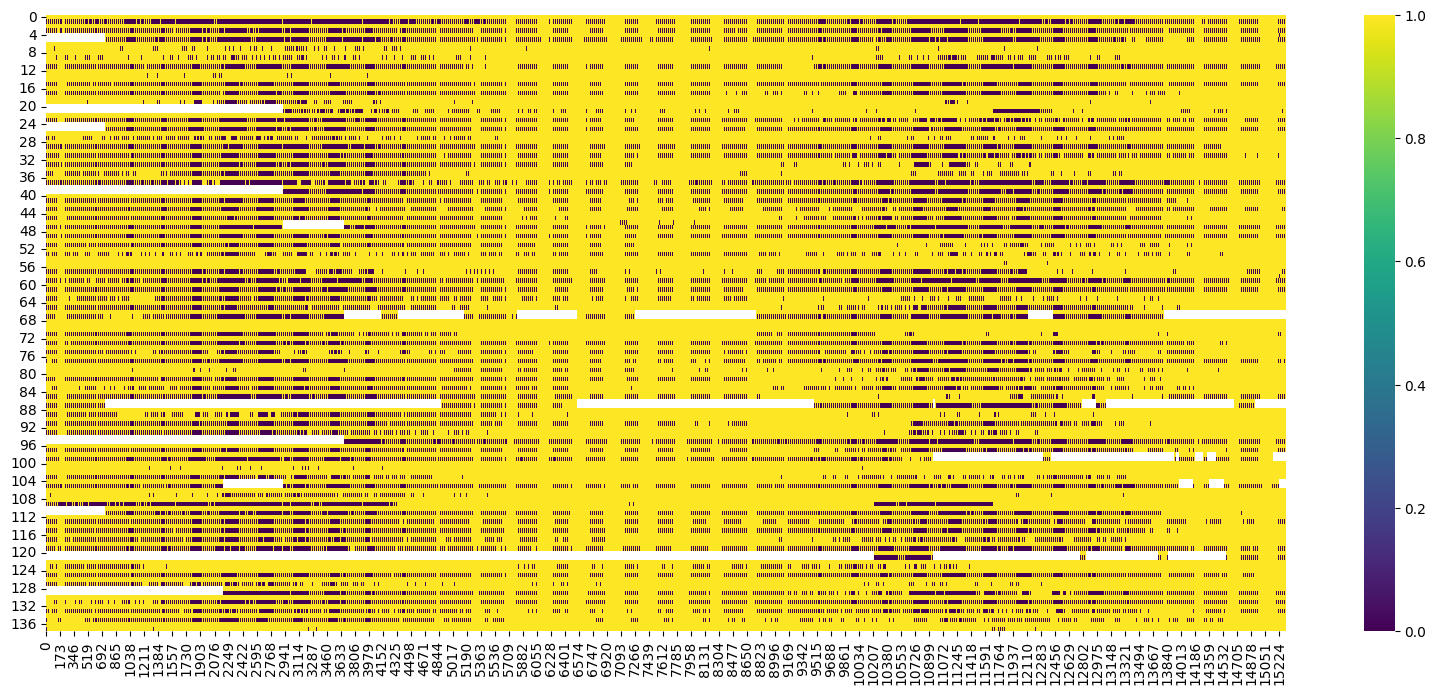

In [71]:
# fig, ax = plt.subplots(figsize=(20, 80))
# sns.heatmap(
#     missmap,
#     # cmap='Paired',
#     cmap="viridis",
#     cbar=False,
# )
# missmap = missmap.T
plt.figure(figsize=(20, 8))
sns.heatmap(
    missmap,
    # cmap='Paired',
    cmap="viridis",
    cbar=True,
)
plt.show()

In [72]:
simple_df = pd.DataFrame({'a': range(1, 6), 'b': range(-20, -15), 'c': range(123, 128)})
simple_df

a   b    c
0  1 -20  123
1  2 -19  124
2  3 -18  125
3  4 -17  126
4  5 -16  127

In [73]:
test = df.assign(
    category_index=df.groupby(
        [
            "county",
            "is_business",
            "product_type",
            "is_consumption",
        ],
        observed=True,
    ).ngroup()
)[["datetime", "target", "category_index"]]
test["datetime"] = (
    (test["datetime"] - test["datetime"].min()) / pd.Timedelta(hours=1)
).astype(int)
test = test.rename(columns={"datetime": "hour_stamp"})
test.target = test.target.where(((test.target == 0) + (test.target.isna())), 1)
test = test.pivot(columns='category_index', index='hour_stamp', values='target' )

test.head()

category_index  0    1    2    3    4    5    6    7    8    9    ...  128  \
hour_stamp                                                        ...        
0               1.0  0.0  1.0  0.0  NaN  NaN  1.0  1.0  1.0  1.0  ...  NaN   
1               1.0  0.0  1.0  0.0  NaN  NaN  1.0  1.0  1.0  1.0  ...  NaN   
2               1.0  0.0  1.0  0.0  NaN  NaN  1.0  1.0  1.0  1.0  ...  NaN   
3               1.0  0.0  1.0  0.0  NaN  NaN  1.0  1.0  1.0  1.0  ...  NaN   
4               1.0  0.0  1.0  0.0  NaN  NaN  1.0  1.0  1.0  1.0  ...  NaN   

category_index  129  130  131  132  133  134  135  136  137  
hour_stamp                                                   
0               NaN  1.0  1.0  1.0  0.0  1.0  0.0  1.0  0.0  
1               NaN  1.0  1.0  1.0  0.0  1.0  0.0  1.0  0.0  
2               NaN  1.0  1.0  1.0  0.0  1.0  0.0  1.0  0.0  
3               NaN  1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  
4               NaN  1.0  1.0  1.0  0.0  1.0  0.0  1.0  0.0  

[5 rows x 138 columns]

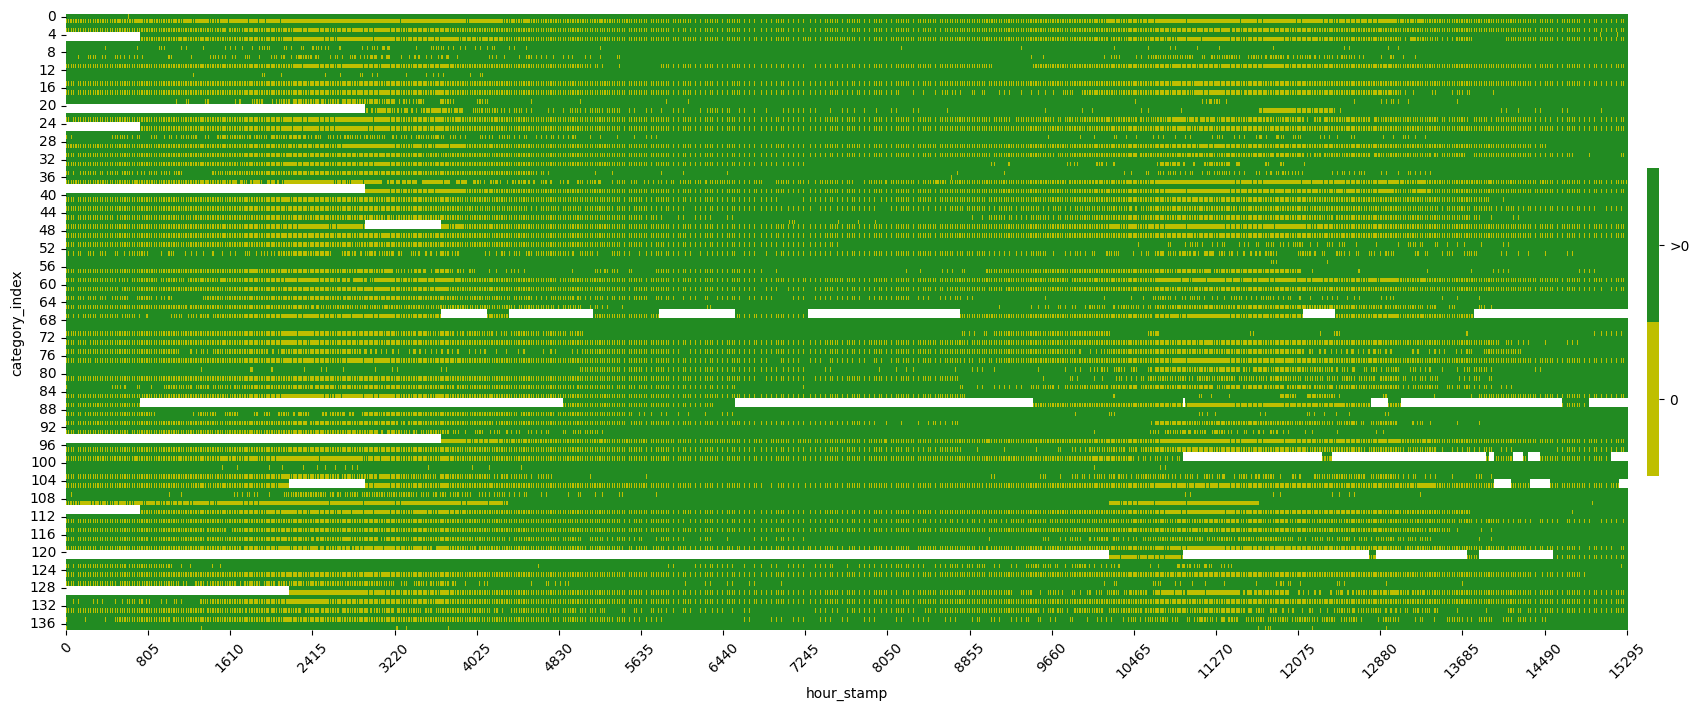

In [74]:
from matplotlib.colors import ListedColormap

plt.figure(figsize=(24, 8))

cmap = ListedColormap(["y", "forestgreen"])
xticks = 19  # Desired number -1
max_hour_range = test.index[-1]

ax = sns.heatmap(
    test.T,
    cmap=cmap,
    cbar_kws={
        "shrink": 0.5,
        "pad": 0.01,
        "aspect": 25,
        "ticks": [0.25, 0.75],
    },
)
colorbar = ax.collections[0].colorbar
colorbar.set_ticklabels(["0", ">0"])

plt.xticks(
    ticks=range(0, max_hour_range, int(max_hour_range / xticks)),
    labels=range(0, max_hour_range, int(max_hour_range / xticks)),
    rotation=45,
)
plt.show()

# CONCLUSION FROM HEATMAP

In [75]:
def target_percentage_in_subgroup(
    df: pd.DataFrame, feature: str, broken_down_by: str, target: str
) -> pd.DataFrame:
    df = (
        df.groupby([broken_down_by, feature], observed=True)[[target]]
        .sum()
        .groupby(level=0, observed=True)
        .apply(lambda x: x * 100 / x.sum())
        .reset_index(level=0, drop=True)
        .reset_index()
        .rename(columns={"target": "percentage"})
    )
    return df

In [76]:
def plot_for_categorical_feature(
    df: pd.DataFrame,
    broken_down_by: str,
    features_list: list[str],
    target: str,
):
    length = len(features_list)
    fig, axs = plt.subplots(
        nrows=length,
        ncols=1,
        figsize=(16, 15),
    )
    fig.tight_layout(pad=5)

    for idx, feature in enumerate(features_list):
        plt.subplot(length, 1, 1 + idx)
        data = target_percentage_in_subgroup(
            df, feature, broken_down_by, target
        )

        barplot = sns.barplot(
            data=data,
            x="percentage",
            y=feature,
            hue=broken_down_by,
        )

        for container in barplot.containers:
            barplot.bar_label(
                container,
                fmt="%.2f",
            )

        plt.title(f"{feature} broken down by {broken_down_by}")
    plt.show()

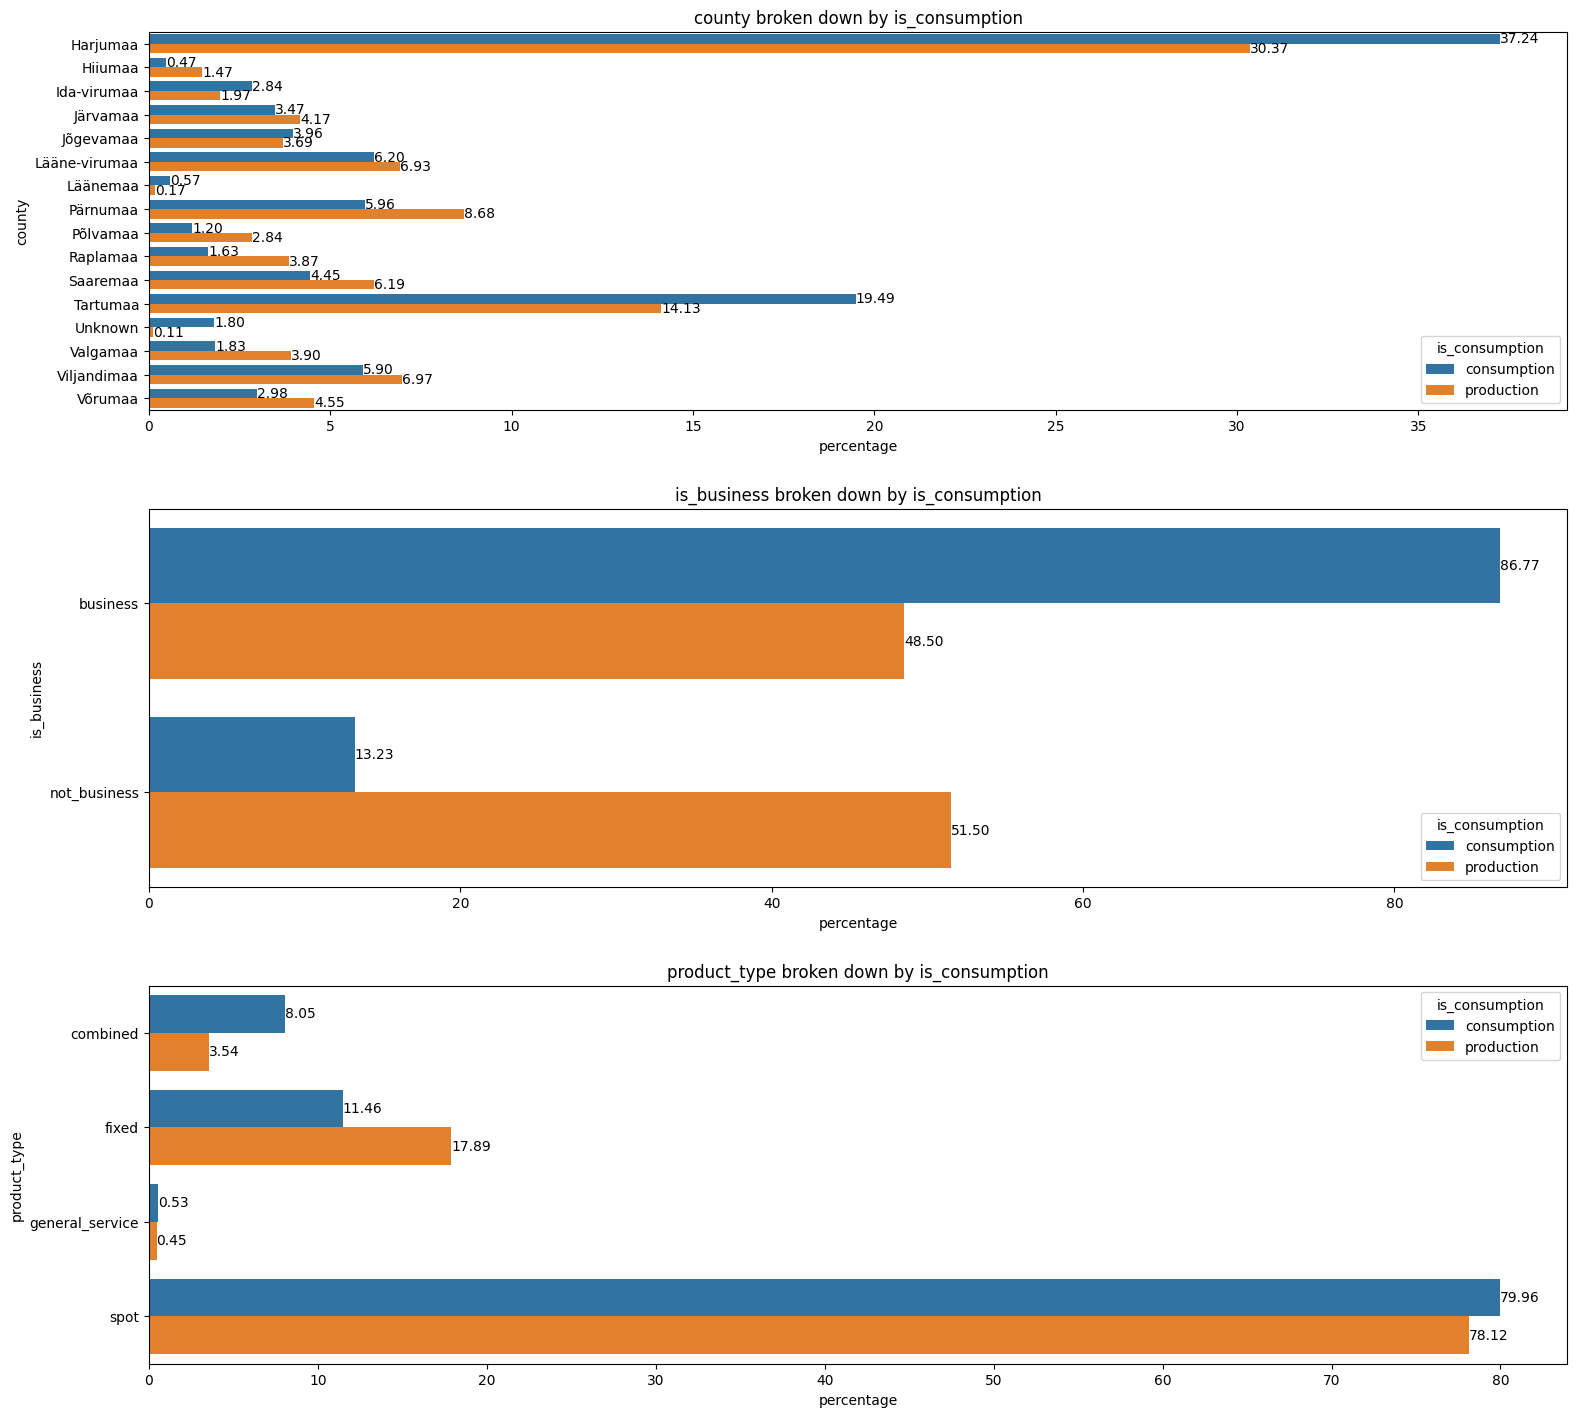

In [77]:
plot_for_categorical_feature(
    df,
    "is_consumption",
    ["county", "is_business", "product_type"],
    "target",
)

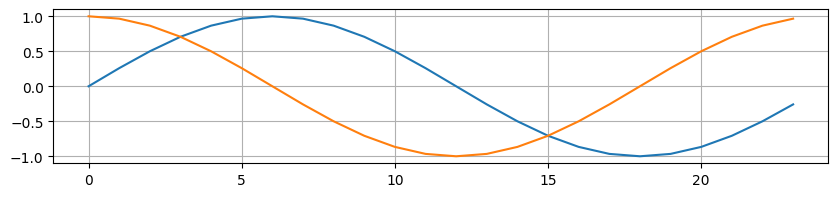

In [78]:
fig, ax = plt.subplots(figsize=(10, 2))
length = 24

sns.lineplot(
    data=[np.sin((2 * i * np.pi / (length))) for i in range(length)],
)
sns.lineplot(
    data=[np.cos(i / (length / 2 / np.pi)) for i in range(length)],
)
# sns.lineplot(
#     data=[np.sin((i * np.pi / 7)) for i in range(length)],
# )
# sns.lineplot(
#     data=[np.tan((i / (len / np.pi)) + np.pi/2 + np.pi/len) for i in range(len)],
# )

# plt.xticks(range(-1, 25))
# plt.yscale('symlog')
plt.grid()
plt.show()

# Feature Engineering

In [79]:
df_hours = df.copy()

hours_ago = (
    [i for i in range(1, 25)]
    + [24 * i for i in range(2, 8)]
    + [168 * i for i in range(2, 9)]
    + [672 * i for i in range(3, 13)]
)
for h in hours_ago:
    df_hours[f"tm_{h}h"] = df_hours["modified_target"].shift(h)
df_hours.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 65 columns):
 #   Column              Dtype         
---  ------              -----         
 0   county              category      
 1   is_business         category      
 2   product_type        category      
 3   target              float64       
 4   is_consumption      category      
 5   datetime            datetime64[ns]
 6   data_block_id       int64         
 7   row_id              int64         
 8   prediction_unit_id  int64         
 9   hour                uint8         
 10  day_of_week         uint8         
 11  day                 uint16        
 12  week_of_year        int8          
 13  month               int8          
 14  quarter             int8          
 15  year                uint16        
 16  date                object        
 17  modified_target     float64       
 18  tm_1h               float64       
 19  tm_2h               float64       
 20  tm

In [80]:
df["tm_1h"] = df["modified_target"].shift(1)

In [81]:
df.shift(periods=1)

county   is_business     product_type   target is_consumption  \
0             NaN           NaN              NaN      NaN            NaN   
1        Harjumaa  not_business            fixed    0.713     production   
2        Harjumaa  not_business            fixed   96.590    consumption   
3        Harjumaa  not_business  general_service    0.000     production   
4        Harjumaa  not_business  general_service   17.314    consumption   
...           ...           ...              ...      ...            ...   
2018347   Võrumaa      business         combined    0.000     production   
2018348   Võrumaa      business         combined  197.233    consumption   
2018349   Võrumaa      business            fixed    0.000     production   
2018350   Võrumaa      business            fixed   28.404    consumption   
2018351   Võrumaa      business             spot    0.000     production   

                   datetime  data_block_id     row_id  prediction_unit_id  \
0                       NaT            NaN        NaN                 NaN   
1       2021-09-01 00:00:00            0.0        0.0                 0.0   
2       2021-09-01 00:00:00            0.0        1.0                 0.0   
3       2021-09-01 00:00:00            0.0        2.0                 1.0   
4       2021-09-01 00:00:00            0.0        3.0                 1.0   
...                     ...            ...        ...                 ...   
2018347 2023-05-31 23:00:00          637.0  2018346.0                64.0   
2018348 2023-05-31 23:00:00          637.0  2018347.0                64.0   
2018349 2023-05-31 23:00:00          637.0  2018348.0                59.0   
2018350 2023-05-31 23:00:00          637.0  2018349.0                59.0   
2018351 2023-05-31 23:00:00          637.0  2018350.0                60.0   

         hour  day_of_week   day  week_of_year  month  quarter    year  \
0         NaN          NaN   NaN           NaN    NaN      NaN     NaN   
1         0.0          2.0   1.0          35.0    9.0      3.0  2021.0   
2         0.0          2.0   1.0          35.0    9.0      3.0  2021.0   
3         0.0          2.0   1.0          35.0    9.0      3.0  2021.0   
4         0.0          2.0   1.0          35.0    9.0      3.0  2021.0   
...       ...          ...   ...           ...    ...      ...     ...   
2018347  23.0          2.0  31.0          22.0    5.0      2.0  2023.0   
2018348  23.0          2.0  31.0          22.0    5.0      2.0  2023.0   
2018349  23.0          2.0  31.0          22.0    5.0      2.0  2023.0   
2018350  23.0          2.0  31.0          22.0    5.0      2.0  2023.0   
2018351  23.0          2.0  31.0          22.0    5.0      2.0  2023.0   

               date  modified_target    tm_1h  
0              None              NaN      NaN  
1        2021-09-01            0.713      NaN  
2        2021-09-01          -96.590    0.713  
3        2021-09-01            0.000  -96.590  
4        2021-09-01          -17.314    0.000  
...             ...              ...      ...  
2018347  2023-05-31            0.000 -117.332  
2018348  2023-05-31         -197.233    0.000  
2018349  2023-05-31            0.000 -197.233  
2018350  2023-05-31          -28.404    0.000  
2018351  2023-05-31            0.000  -28.404  

[2018352 rows x 19 columns]

In [82]:
# def add_lags(df):
#     target_map = df['PJME_MW'].to_dict()
#     df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
#     df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
#     df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
#     return df

In [83]:
df_label = pd.get_dummies(df_label, drop_first=True)
df_label.info()

NameError: name 'df_label' is not defined

In [ ]:
df_label.columns

In [ ]:
X = df_label.drop(
    columns=[
        "target",
        "data_block_id",
        "row_id",
        "prediction_unit_id",
        "modified_target",
    ],
    axis=1,
)

y = df_label["modified_target"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RAND
)

st = StandardScaler()
X_train_std = st.fit_transform(X_train)
X_test_std = st.transform(X_test)

In [ ]:
def r2_adjusted(
    y_true: np.ndarray, y_pred: np.ndarray, X_test: np.ndarray | int
) -> float:
    """Коэффициент детерминации (множественная регрессия)"""
    N_objects = len(y_true)

    if isinstance(X_test, np.ndarray):
        N_features = X_test.shape[1]
    else:
        N_features = X_test

    #     N_features = X_test.shape[1]
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (N_objects - 1) / (N_objects - N_features - 1)


def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Mean percentage error"""
    return np.mean((y_true - y_pred) / y_true, axis=0) * 100


def mape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Mean absolute percentage error"""
    return np.mean(np.abs((y_pred - y_true) / y_true), axis=0) * 100


def wape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Weighted Absolute Percent Error"""
    return np.sum(np.abs(y_pred - y_true)) / np.sum(y_true) * 100


def huber_loss(
    y_true: np.ndarray | pd.DataFrame,
    y_pred: np.ndarray | pd.DataFrame,
    delta: float = 1.345,
):
    """Функция ошибки Хьюбера"""

    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.squeeze().to_numpy()
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.squeeze().to_numpy()

    assert len(y_true) == len(y_pred), "Разные размеры данных"
    huber_sum = 0
    for i in range(len(y_true)):
        if abs(y_true[i] - y_pred[i]) <= delta:
            huber_sum += 0.5 * (y_true[i] - y_pred[i]) ** 2
        else:
            huber_sum += delta * (abs(y_true[i] - y_pred[i]) - 0.5 * delta)
    huber_sum /= len(y_true)
    return huber_sum


def logcosh(y_true: np.ndarray, y_pred: np.ndarray):
    """функция ошибки Лог-Кош"""
    return np.sum(np.log(np.cosh(y_true - y_pred)))


def rmsle(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    """
    Root Mean Squared Log Error (RMSLE) metric
    Логарифмическая ошибка средней квадратичной ошибки
    """
    try:
        return np.sqrt(mean_squared_log_error(y_true, y_pred))
    except:
        return None


def get_metrics(
    y_test: np.ndarray,
    y_pred: np.ndarray,
    X_test: np.ndarray,
    name: str = None,
    delta: float = 1.345,
):
    """Генерация таблицы с метриками"""
    df_metrics = pd.DataFrame()
    df_metrics["model"] = [name]

    df_metrics["MAE"] = mean_absolute_error(y_test, y_pred)
    df_metrics["MSE"] = mean_squared_error(y_test, y_pred)
    df_metrics["Huber_loss"] = huber_loss(y_test, y_pred, delta)
    df_metrics["Logcosh"] = logcosh(y_test, y_pred)
    df_metrics["RMSE"] = np.sqrt(mean_squared_error(y_test, y_pred))
    df_metrics["RMSLE"] = rmsle(y_test, y_pred)
    df_metrics["R2 adjusted"] = r2_adjusted(y_test, y_pred, X_test)
    df_metrics["MPE_%"] = mpe(y_test, y_pred)
    df_metrics["MAPE_%"] = mape(y_test, y_pred)
    df_metrics["WAPE_%"] = wape(y_test, y_pred)

    return df_metrics

In [ ]:
lr_skl = LinearRegression()
lr_skl.fit(X_train_std, y_train)

In [ ]:
lr_skl_pred = lr_skl.predict(X_test_std)

In [ ]:
skl_m = get_metrics(y_test, lr_skl_pred, X_test_std, name="skl_lr")
skl_m

In [ ]:
df_hours = df_hours[
    [
        "county",
        "is_business",
        "product_type",
        "target",
        "is_consumption",
        "hour",
        "day_of_week",
        "day",
        "week_of_year",
        "month",
        "quarter",
        "year",
        "modified_target",
        "tm_1h",
        "tm_2h",
        "tm_3h",
        "tm_4h",
        "tm_5h",
        "tm_6h",
        "tm_7h",
        "tm_8h",
        "tm_9h",
        "tm_10h",
        "tm_11h",
        "tm_12h",
        "tm_13h",
        "tm_14h",
        "tm_15h",
        "tm_16h",
        "tm_17h",
        "tm_18h",
        "tm_19h",
        "tm_20h",
        "tm_21h",
        "tm_22h",
        "tm_23h",
        "tm_24h",
        "tm_48h",
        "tm_72h",
        "tm_96h",
        "tm_120h",
        "tm_144h",
        "tm_168h",
        "tm_336h",
        "tm_504h",
        "tm_672h",
        "tm_840h",
        "tm_1008h",
        "tm_1176h",
        "tm_1344h",
        "tm_2016h",
        "tm_2688h",
        "tm_3360h",
        "tm_4032h",
        "tm_4704h",
        "tm_5376h",
        "tm_6048h",
        "tm_6720h",
        "tm_7392h",
        "tm_8064h",
    ]
]

In [ ]:
df_hours = df_hours.sort_index()
tss = TimeSeriesSplit(n_splits=3, test_size=300_000)

In [ ]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df_hours):
    train = df_hours.iloc[train_idx]
    test = df_hours.iloc[val_idx]

    reg = XGBRegressor(
        n_estimators=2000,
        early_stopping_rounds=50,
        objective="reg:squarederror",
        enable_categorical=True,
        eval_metric="mae",
        # max_depth=3,
        learning_rate=0.01,
        random_state=RAND,
    )
    FEATURES = [
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "hour",
        "day_of_week",
        "day",
        "week_of_year",
        "month",
        "quarter",
        "year",
        "tm_1h",
        "tm_2h",
        "tm_3h",
        "tm_4h",
        "tm_5h",
        "tm_6h",
        "tm_7h",
        "tm_8h",
        "tm_9h",
        "tm_10h",
        "tm_11h",
        "tm_12h",
        "tm_13h",
        "tm_14h",
        "tm_15h",
        "tm_16h",
        "tm_17h",
        "tm_18h",
        "tm_19h",
        "tm_20h",
        "tm_21h",
        "tm_22h",
        "tm_23h",
        "tm_24h",
        "tm_48h",
        "tm_72h",
        "tm_96h",
        "tm_120h",
        "tm_144h",
        "tm_168h",
        "tm_336h",
        "tm_504h",
        "tm_672h",
        "tm_840h",
        "tm_1008h",
        "tm_1176h",
        "tm_1344h",
        "tm_2016h",
        "tm_2688h",
        "tm_3360h",
        "tm_4032h",
        "tm_4704h",
        "tm_5376h",
        "tm_6048h",
        "tm_6720h",
        "tm_7392h",
        "tm_8064h",
    ]
    # TARGET = "modified_target"
    TARGET = "target"

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=20,
    )

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

In [ ]:
hours_ago = (
    [i for i in range(1, 25)]
    + [24 * i for i in range(2, 8)]
    + [168 * i for i in range(2, 9)]
    + [672 * i for i in range(3, 13)]
)
for h in hours_ago:
    df[f"t_{h}h"] = df["target"].shift(h)

In [ ]:
fig, ax = plt.subplots(figsize=(35, 30))

sns.heatmap(df_hours.corr(), annot=True, cmap="Blues", fmt=".1f")
# plt.figure(figsize=(25, 25))
plt.show()
# numeric_only=True

In [ ]:
# df = df.sort_index().sort_values(
#     ["county", "is_business", "product_type", "is_consumption"],
#     kind="mergesort",
# )
df.sort_index()
tss = TimeSeriesSplit(n_splits=3, test_size=300_000)

In [ ]:
a = {}
for i in range(1000):
    x = 0;
    for j in range(20):
        x += np.random.choice([-1,1])
    a[x] = a.get(x, 0) + 1;


sns.barplot(x=list(a.keys()), y=list(a.values()));

In [ ]:
# min(data.keys())
# max(data.keys())
# len(data.keys())
# {k: 0 for (k, 0) in range(min(data.keys()), max(data.keys())) if not in data.keys()}
# {k: v*2 for (k,v) in dict1.items()}
# {key:value for (key,value) in dictonary.items()}
# zip()
data

In [ ]:
data

In [ ]:
# for train_idx, val_idx in tss.split(df):
# print('1 train:', train_idx)
# display(df.iloc[train_idx].tail(5))
# print('1 val:', val_idx)

In [ ]:
tss = TimeSeriesSplit(n_splits=3, test_size=300_000)
df = df.sort_index()

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
fold = 0

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train["modified_target"].plot(
        ax=axs[fold],
        label="Training Set",
        title=f"Data Train/Test Split Fold {fold}",
    )
    test["modified_target"].plot(ax=axs[fold], label="Test Set")
    axs[fold].axvline(test.index.min(), color="black", ls="--")
    fold += 1
plt.show()

In [ ]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    reg = XGBRegressor(
        n_estimators=2000,
        early_stopping_rounds=50,
        objective="reg:squarederror",
        enable_categorical=True,
        eval_metric="mae",
        # max_depth=3,
        learning_rate=0.01,
        random_state=RAND,
    )
    FEATURES = [
        "county",
        "is_business",
        "product_type",
        # 'target',
        "is_consumption",
        # 'data_block_id',
        # 'row_id',
        # 'prediction_unit_id',
        "hour",
        "day_of_week",
        "day",
        "week_of_year",
        "month",
        "quarter",
        "year",
        # 'modified_target',
    ]
    TARGET = "modified_target"

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=20,
    )

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)